#Homework 1

In [1666]:
##PCA:

In [1667]:
#Globals
import pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import collections
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

TEST_MODE = 1
PCAResult = collections.namedtuple('PCAResult', ['eigenValues', 'eigenVectors', 'mean', 'deviation'])
LDAResult = collections.namedtuple('LDAResult', ['eigenValues', 'eigenVectors', 'mean', 'deviation'])
identificationStrings = ["5 samples", "50 samples", "10-fold cross validation"]

In [1668]:
#Visualization routines
def VisualizeCumulativeSum(values):
    sumValues = np.linalg.norm(values, 1)
    plt.plot(np.arange(0,values.shape[0]), values/sumValues, color='y')
    plt.plot(np.arange(0,values.shape[0]), values/sumValues, 'o', color='r')
    plt.show()
    
def VisualizeEigenVector(vectors, index):
    print(vectors[:, index])

def VisualizeEigenImage(vectors, index):
    image = vectors[:,index]
    plt.subplots(1)
    plt.imshow(image.reshape(28,28).T, origin='upper', cmap = cm.Greys_r)
    plt.show()
    
#Given an object with eigenVectors, visualize the eigenVectors at the passed in indices
def visualizeEigenvectors(result, visualizationFunction, eigenVectorIndices):
    VisualizeCumulativeSum( result.eigenValues )
    for eigenVectorIndex in eigenVectorIndices:
        print("%dth eigenvector: " %(eigenVectorIndex))
        visualizationFunction( result.eigenVectors, eigenVectorIndex )

In [1669]:
#Data handling routings
def getTrainingData(iteration, data, classColumn, classLabels):   
    trainingData = pandas.DataFrame()
    if iteration != 2:
        numSamples = 5 if iteration == 0 else 50
        for classLabel in classLabels:
            trainingData = trainingData.append(data[data[classColumn] == classLabel].sample(numSamples))
    else:
        for classLabel in classLabels:
            trainingData = trainingData.append(data[data[classColumn] == classLabel].sample(numSamples))
    return trainingData

In [1670]:
#PCA
#Calculate sorted eigenValues and eigenVectors for passed in data. Data is assumed to consist of one data-point in each row
def PCA(data):
    mean = data.mean(axis=0)
    centeredData = data - mean
    deviation = centeredData.std(axis = 0);
    scaledData = centeredData / deviation
    scaledData[:,deviation == 0] = 0

    eigenVectors, eigenValues,V = np.linalg.svd(scaledData.transpose(), full_matrices=False)
    eigenValues = (eigenValues**2)/(data.shape[0]-1)

    if TEST_MODE:
        #Check things are what they seem using self written functions
        covariance = np.cov(scaledData, rowvar=0)
        covSelf = (scaledData.transpose().dot(scaledData))/(scaledData.shape[0]-1)
        assert(np.allclose(covariance, covSelf))
        testValues, testVectors = np.linalg.eigh(covariance)
        testValues = testValues[::-1] #Eigh returns these in ascending order
        testVectors = testVectors[::-1]
        assert(np.allclose(eigenValues, testValues[:len(eigenValues)])) #See eigenvalues are close
        assert(np.allclose(eigenVectors[:,1].dot(eigenVectors[:,5].T), 0)) #See that columns are orthogonal       

    return eigenValues, eigenVectors

For my implementation of PCA, I show the 10th eigenvector instead of the 20th, as the 20th is zero as the data is 13-dimensional. The most important eigenvector, the 10th eigenvector and the plot for the ratio of the sorted eigenvalues to the sum of the eigenvalues for the wine dataset for two runs, one with 5 and the other time with 50 random samples of each class selected for training are:

In [1671]:
def performPCA(data, pcaResult):
    eValues, eVectors = PCA(data)
    mean = data.mean(axis=0)
    centeredData = data - mean
    pcaResult.append(PCAResult(eValues, eVectors, mean, centeredData.std(axis = 0)))
    
def readData(dataPath, columnHeaders):
    loadedData = pandas.read_csv(dataPath, names=columnHeaders)
    return loadedData
       
#Show the reconstruction and the reconstruction error
def getReconstruction(pcaResult, testSample, threshHold):
    sumValues = pcaResult.eigenValues.sum()
    scaledValues = pcaResult.eigenValues/sumValues
    for j in range(0,pcaResult.eigenValues.shape[0]):
        if scaledValues[j] < threshhold:
            break

    #Decide number of eigenvectors to use
    numToUse = j+1
    
    #if TEST_MODE:
    #   #Use all eigenVectors and see that reconstruction error is zero
    #   numToUse = eigenValues[i].shape[0] 
    #print("Number of eigenvectors being used ", numToUse)
    
    basis = pcaResult.eigenVectors[:,:numToUse].T
    projection = basis.dot(testSample.T)
    reconstruction = (basis.T.dot(projection)).T

    #if TEST_MODE:
    #    assert(np.allclose(np.linalg.norm(basis[:,0]), 1)) #Unit basis
    #    assert(np.allclose(basis[:,1].dot(basis[:,5].T), 0)) #Orthogonal basis
    #    assert(np.allclose(reconstruction - testSample, 0)) #Complete reconstruction
    return reconstruction


Using 5 samples for training:


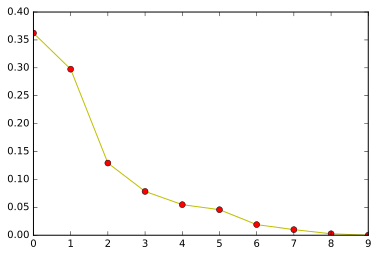

0th eigenvector: 
[-0.31441276  0.15537282  0.28556388  0.42465423 -0.17102686 -0.22870942
 -0.26281017  0.31143548 -0.332402   -0.34050401 -0.07587707  0.08009949
 -0.35902534]
9th eigenvector: 
[ 0.45152165 -0.03960405 -0.06936737 -0.46369664 -0.28265396  0.01411921
 -0.49190534  0.43833879  0.02122825 -0.13798601  0.07599613 -0.16390722
 -0.09163611]

Using 50 samples for training:


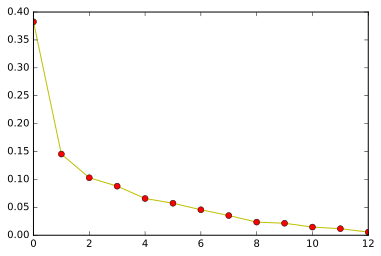

0th eigenvector: 
[-0.35292705 -0.00660818 -0.13965007  0.17601647 -0.23685873 -0.36768697
 -0.3847511   0.25283531 -0.26175485 -0.37572128 -0.03391974 -0.27229803
 -0.36970417]
9th eigenvector: 
[-0.28749883 -0.10218367  0.55767512 -0.69373689  0.03069242 -0.11526041
  0.03572359 -0.00392964  0.13891836 -0.06907128 -0.09962081  0.03317771
 -0.25301717]


In [1672]:
# Analyze the wine-database first
# Change this to location of data-bases
wineDataPath = "data/wine.data"
headers = ['Lab','Alc','Ma','Ash','Alk','Mag','Phe','Fla','NoFla','Pro','Col','Hue','OD','Pr']

loadedData = readData(wineDataPath, headers)
classLabels = [1,2]
classColumnName = headers[0]
filteredData = loadedData[loadedData[classColumnName].isin(classLabels)]

pcaResult = []
for iteration in range(0,2):
    trainingData = getTrainingData(iteration, filteredData, classColumnName, classLabels)
    trainingLabels = trainingData[classColumnName]
    trainingDataUnlabeled = trainingData.drop(classColumnName, axis=1)
    
    testingData = loadedData.drop(trainingData.index)
    testingLabels = testingData[classColumnName]
    testingDataUnlabeled = testingData.drop(classColumnName, axis=1)

    print("\nUsing %s for training:" %(identificationStrings[iteration]))
    performPCA(trainingDataUnlabeled.as_matrix(), pcaResult) 
    visualizeEigenvectors(pcaResult[iteration], VisualizeEigenVector, [0,9])

I also use a variable number of eigenvectors for the reconstruction, discarding those for which the ratio: (eigenvalue)/(sum of eigenvalues) falls below a threshhold (I use a threshhold of 0.03). Using this to reconstruct a test-example, I get the following reconstruction errors:

In [1673]:
#Wine data continue visualization
testingSample = testingDataUnlabeled.sample()
threshHold = 0.03

for iteration in range(0,len(pcaResult)):   
    print("When using %s for training:" %(identificationStrings[iteration]))

    #First normalize and center-mean the sample
    centeredSample = testingSample - pcaResult[iteration].mean
    normalizedSample = centeredSample / pcaResult[iteration].deviation

    reconstruction = getReconstruction(pcaResult[iteration], normalizedSample, threshHold)
    print("Reconstruction error:", np.linalg.norm(reconstruction - normalizedSample), "\n")

When using 5 samples for training:
Reconstruction error: 3.45652680653 

When using 50 samples for training:
Reconstruction error: 1.68920174833 



In [1674]:
#Analyze mnist
## Change this to location of data-bases
mnistTrainDataPath = "data/train.csv"
mnistTestDataPath = "data/test.csv"

mnistTrainData = pandas.read_csv(mnistTrainDataPath, header=None)
mnistTrainData = mnistTrainData.transpose()
mnistTestData = pandas.read_csv(mnistTestDataPath, header=None)
mnistTestData = mnistTestData.transpose()

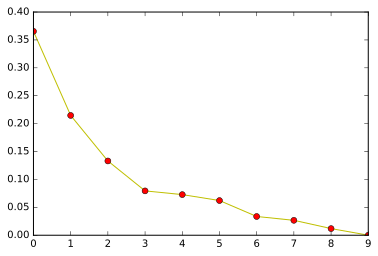

0th eigenvector: 


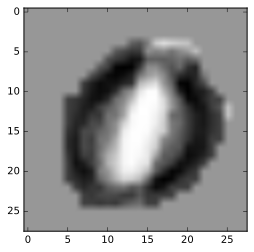

9th eigenvector: 


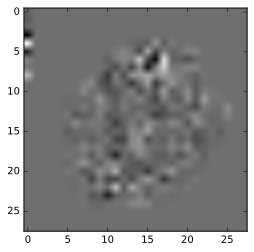

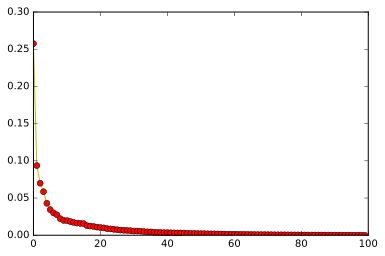

0th eigenvector: 


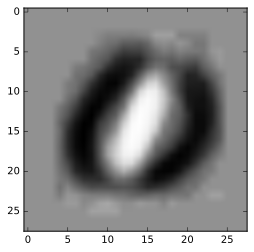

20th eigenvector: 


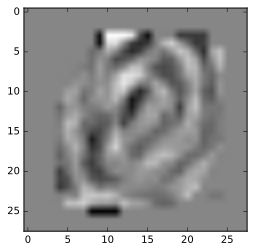

In [1675]:
classLabels=[0,1]
classColumnName = 784

trainData = mnistTrainData[mnistTrainData[classColumnName].isin(classLabels)]
testData =  mnistTestData[mnistTestData[classColumnName].isin(classLabels)]

pcaResult = []

for iteration in range(0,2):
    trainingData = getTrainingData(iteration, trainData, classColumnName, classLabels)
    trainingLabels = trainingData[classColumnName]
    trainingDataUnlabeled = trainingData.drop(classColumnName, axis=1)

    testingData = testData
    testingLabels = testingData[classColumnName]
    testingDataUnlabeled = testingData.drop(classColumnName, axis=1)

    performPCA(trainingDataUnlabeled.as_matrix(), pcaResult)
    visualizeEigenvectors(pcaResult[iteration], VisualizeEigenImage, [0,9 if iteration == 0 else 20])

Similar to the wine data-set, I again use a variable number of eigenvectors for the reconstruction, discarding those for which the ratio: (eigenvalue)/(sum of eigenvalues) falls below a threshhold (I use a threshhold of 0.005 here). Using this to reconstruct a test-example, I get the following reconstruction and errors:

When using 5 samples for training:
Original sample 


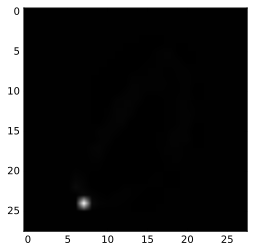

Reconstruction 


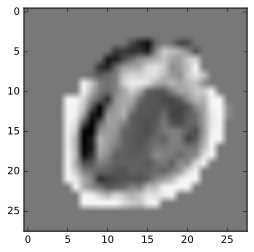

Reconstruction error: 195.744088713 



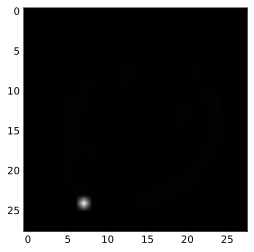

When using 50 samples for training:
Original sample 


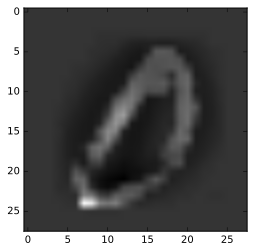

Reconstruction 


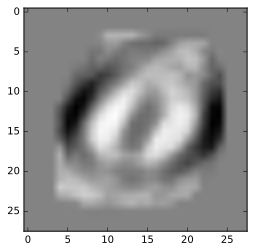

Reconstruction error: 19.5058179787 



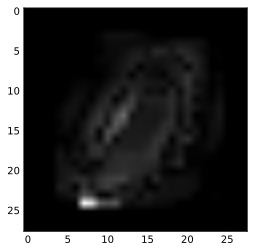

In [1676]:
#Mnist data continue visualization
testingSample = testingDataUnlabeled.sample()
threshHold = 0.005

for iteration in range(0,len(pcaResult)):   
    print("When using %s for training:" %(identificationStrings[iteration]))

    #First normalize and center-mean the sample
    centeredSample = testingSample - pcaResult[iteration].mean
    normalizedSample = (centeredSample / pcaResult[iteration].deviation).as_matrix()
    normalizedSample[:,pcaResult[iteration].deviation == 0] = 0
    
    print("Original sample ")
    VisualizeEigenImage(normalizedSample.transpose(), 0)
    
    print("Reconstruction ")
    reconstruction = getReconstruction(pcaResult[iteration], normalizedSample, threshHold)
    VisualizeEigenImage(reconstruction.transpose(), 0)

    print("Reconstruction error:", np.linalg.norm(reconstruction - normalizedSample).transpose(), "\n")
    VisualizeEigenImage(abs(reconstruction - normalizedSample).transpose(), 0)

##LDA

I perform LDA for class discrimination maximizing dimensionality reduction after performing PCA for class agnostic dimensionality reduction. The most important eigenvector, the 10th eigenvector and the plot for the ratio of the sorted eigenvalues to the sum of the eigenvalues for the wine dataset for two runs, one with 5 and the other time with 50 random samples of each class selected for training are:

In [1677]:
def performLDA(data, labels):
    #eValues, eVectors = 
    result = LDA(data, labels)
    mean = data.mean(axis=0)
    centeredData = data - mean
    #LDA(centeredData, labels)
    #pcaResult.append(PCAResult(eValues, eVectors, mean, centeredData.std(axis = 0)))
    return result

#LDA
#Calculate sorted eigenValues and eigenVectors for passed in data. Data is assumed to consist of one data-point in each row
def LDA(data, labels):
    uniqueLabels = np.unique(labels)
    classDatas, classMeans = [], []
    for classLabel in uniqueLabels:
        classDatas.append(data[labels == classLabel])
    classMeans = [classData.mean(axis=0) for classData in classDatas]
    scaledDatas = classDatas
    #centeredDatas = [classData - classMean for (classData, classMean) in zip(classDatas, classMeans)]
    #deviations = [centeredData.std(axis = 0) for centeredData in centeredDatas]
    #scaledDatas = [centeredData / deviation for (centeredData, deviation) in zip(centeredDatas, deviations)]
    #for (scaledData, deviation) in zip(scaledDatas, deviations): 
    #    scaledData[:,deviation == 0] = 0
    betweenClassScatter = np.outer(classMeans[0] - classMeans[1],classMeans[0] - classMeans[1])
    withinClassScatter = sum(np.cov(scaledData, rowvar=0) for scaledData in scaledDatas)
    desiredMatrix = np.linalg.inv(withinClassScatter).dot(betweenClassScatter)
    eigenValues, eigenVectors = np.linalg.eigh(desiredMatrix)
    eigenValues = eigenValues[::-1] #Eigh returns these in ascending order
    eigenVectors = eigenVectors[::-1]

    if TEST_MODE:
         #Check things are what they seem using self written functions
         withinClassScatter = sum(np.cov(scaledData, rowvar=0) for scaledData in scaledDatas)
         withinClassScatterSelf = sum(scaledData.transpose().dot(scaledData)/(
                                       scaledData.shape[0]-1) for scaledData in scaledDatas)
         #assert(np.allclose(withinClassScatter, withinClassScatterSelf))
         assert(np.allclose(eigenVectors[:,1].dot(eigenVectors[:,5].T), 0)) #See that columns are orthogonal       
    return LDAResult(eigenValues, eigenVectors, None, None)


Using 5 samples for training:


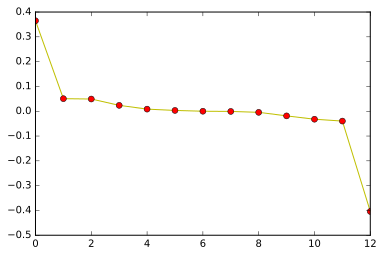

0th eigenvector: 
[-0.00428548  0.00149424 -0.00396002  0.10069194 -0.14997066 -0.0658678
 -0.43478073  0.46112983  0.49604794  0.40207414 -0.13808566 -0.0613661
 -0.36160678]
9th eigenvector: 
[  1.10487831e-02  -5.40088687e-03   1.21461919e-02  -3.23620568e-01
  -5.32492953e-01  -7.62926183e-01   9.68664906e-02  -1.40350655e-01
   1.47532476e-02   6.97184199e-03  -6.50637026e-07  -3.42423790e-03
   2.53664914e-03]

Using 50 samples for training:


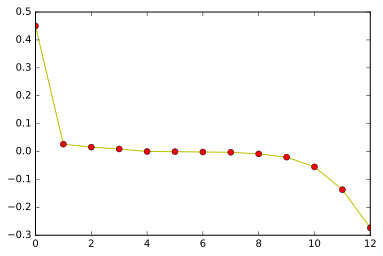

0th eigenvector: 
[ 0.63636289 -0.06367696 -0.06396218  0.28695534  0.11003639 -0.08112451
 -0.41055227  0.09568463  0.0564428   0.18248397  0.01131952 -0.13161695
  0.5042001 ]
9th eigenvector: 
[-0.31857052 -0.16487242 -0.05841136  0.7135323   0.42193921  0.41879007
  0.06549743 -0.00557724  0.01439727 -0.00131737  0.00725932 -0.02599657
 -0.01064434]


In [1678]:
# Analyze the wine-database first
# Change this to location of data-bases
wineDataPath = "data/wine.data"
headers = ['Lab','Alc','Ma','Ash','Alk','Mag','Phe','Fla','NoFla','Pro','Col','Hue','OD','Pr']

loadedData = readData(wineDataPath, headers)
classLabels = [1,2]
classColumnName = headers[0]
filteredData = loadedData[loadedData[classColumnName].isin(classLabels)]

ldaResult, pcaResult = [], []
for iteration in range(0,2):
    trainingData = getTrainingData(iteration, filteredData, classColumnName, classLabels)
    trainingLabels = trainingData[classColumnName]
    trainingDataUnlabeled = trainingData.drop(classColumnName, axis=1)
    
    testingData = loadedData.drop(trainingData.index)
    testingLabels = testingData[classColumnName]
    testingDataUnlabeled = testingData.drop(classColumnName, axis=1)

    print("\nUsing %s for training:" %(identificationStrings[iteration]))    
    performPCA(trainingDataUnlabeled.as_matrix(), pcaResult)
    trainingReducedDim = getReconstruction(pcaResult[iteration], trainingDataUnlabeled.as_matrix(), 0.05)
    ldaResult.append(performLDA(trainingReducedDim, trainingLabels.as_matrix()))
    visualizeEigenvectors(ldaResult[iteration], VisualizeEigenVector, [0,9])

In [1679]:
  #Train
    trainingMeans = [trainingDataUnlabeled[0].mean(), trainingDataUnlabeled[1].mean()]
    trainingVariance = totalTrainingData.var()
    weights = (trainingMeans[1]*trainingMeans[1] - trainingMeans[0]*trainingMeans[0])/trainingVariance
    bias = 0.5 + ((trainingMeans[1]*trainingMeans[1] - trainingMeans[0]*trainingMeans[0])/2*trainingVariance).sum()

    #Test
    #for i in testingData[1].index[0:1]:
    #    data = testingData[1].ix[i]
    #    print(weights, data)
    #    label = 0 if weights.dot(data) > 0 else 1

array1 = np.array([[1,2,3],[0, 1, 2]])
array2 = np.array([0, 1, 1])
result = array1/array2
result[:,array2 == 0] = 0
print(result)

IndentationError: unexpected indent (<ipython-input-1679-c802a46ecf78>, line 2)